In [1]:
% load_ext rpy2.ipython

In [2]:
%%R
library("phyloseq")
library(ggplot2)

In [3]:
%%R
physeq = import_biom("../../SeqData/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)


In [5]:
%%R

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [ ]:
%%R
physeq

In [8]:
%%R
ps.FQS = subset_samples(physeq,sample_data(physeq)$Trtmt=="F"|sample_data(physeq)$Trtmt=="Q"|sample_data(physeq)$Trtmt=="S")

Error in validObject(.Object) : 
  invalid class “sample_data” object: Sample Data must have non-zero dimensions.


In [9]:
%%R
physeq.noSmall<-subset_samples(physeq,sample_sums(physeq)>1000)

In [10]:
%%R
ps <- physeq.noSmall

In [11]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
ps_snorm = transform_sample_counts(ps, function(x) x / sum(x))

In [12]:
%%R
# Computing the Bray distance matrix and NMDS in parallel

ord.full = ordinate(ps_snorm, method = "NMDS", distance = "bray", k=3, trymax=40)
ord.full.plot = plot_ordination(ps_snorm, ord.full, axes = c(1,2), justDF = TRUE)
ord.full.plot$Samples = rownames(ord.full.plot)

Run 0 stress 0.1280525 
Run 1 stress 0.1255049 
... New best solution
... procrustes: rmse 0.07041672  max resid 0.179926 
Run 2 stress 0.1314407 
Run 3 stress 0.1313375 
Run 4 stress 0.1315367 
Run 5 stress 0.1302293 
Run 6 stress 0.1268127 
Run 7 stress 0.1268027 
Run 8 stress 0.1300861 
Run 9 stress 0.1267653 
Run 10 stress 0.1282079 
Run 11 stress 0.1281013 
Run 12 stress 0.1297429 
Run 13 stress 0.1289444 
Run 14 stress 0.1292526 
Run 15 stress 0.1302061 
Run 16 stress 0.1255271 
... procrustes: rmse 0.006478701  max resid 0.03440016 
Run 17 stress 0.1313953 
Run 18 stress 0.1268773 
Run 19 stress 0.1294124 
Run 20 stress 0.1284305 
Run 21 stress 0.1268561 
Run 22 stress 0.1290599 
Run 23 stress 0.1306111 
Run 24 stress 0.1255451 
... procrustes: rmse 0.007104841  max resid 0.03940177 
Run 25 stress 0.1282391 
Run 26 stress 0.1292627 
Run 27 stress 0.1285789 
Run 28 stress 0.1255079 
... procrustes: rmse 0.0006231093  max resid 0.002199594 
*** Solution reached


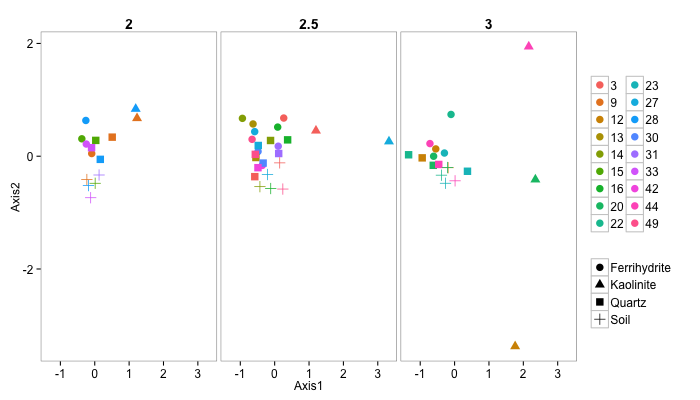

In [14]:
%%R -h 400 -w 700
D <- ord.full.plot
# Sets the relevant ordination

colnames(D)[1:2]<-c("Axis1","Axis2")
# Renames the axis columns

D$Month<-as.factor(D$Month)
D$Cosm<-as.factor(D$Cosm)

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = Axis1, y = Axis2, color = Cosm, shape = Trtmt))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) 
#+ scale_colour_manual(values=c("skyblue3","orange","chartreuse4","gold1","red3","black"))

p = p + guides(colour = guide_legend("", ncol = 2), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),axis.text = element_text(size=12),legend.text = element_text(size=12),
          strip.background = element_rect(colour="white", fill="white"))

p = p + facet_grid(~Month)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days

p

I need to calculate similarity distances between all units and see if the values are closer for related microcosms.  
See Soil_Effect notebook. There is not a significant difference detected.